Viz Features to work on:

Create topic ontology

Additional columns to work on
- isLocal, locale (country)
- human language

Nits
- reorder in likely level of interest - topics first

Export using
```
jupyter nbconvert --no-input --output-dir=docs --output=index covid-project-report.ipynb --to html --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FixedLocator, LogLocator
from IPython.display import Markdown as md
import numpy as np
import seaborn as sns
import datetime

# CONFIGURATION
date_github_published = '2020-07-20'


COMMA_FMT = StrMethodFormatter('{x:,g}')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title#set ticks every week


In [2]:
# print(date_github_published)
projects = pd.read_csv(date_github_published+'.tsv', sep='\t')
# convert string dates to datetime
projects['repo_created_day'] = pd.to_datetime(projects['repo_created_day'], format='%Y-%m-%d')

md("""
# GitHub covid-19-repo-data report

This is a summary of the data on GitHub COVID-19 projects that is posted by GitHub at https://github.com/github/covid-19-repo-data.

This page is hosted at https://estaub.github.io/covid-project-report/.

Source for this jupyter notebook is at https://github.com/estaub/covid-project-report.  
If you have suggestions for improvements, please feel free to open an issue there.

There are __{} projects__ as of GitHub data release date: __{}__
""".format(f'{len(projects.index):,}',date_github_published))


# GitHub covid-19-repo-data report

This is a summary of the data on GitHub COVID-19 projects that is posted by GitHub at https://github.com/github/covid-19-repo-data.

This page is hosted at https://estaub.github.io/covid-project-report/.

Source for this jupyter notebook is at https://github.com/estaub/covid-project-report.  
If you have suggestions for improvements, please feel free to open an issue there.

There are __95,309 projects__ as of GitHub data release date: __2020-07-20__


In [3]:
##########################
#print(projects.dtypes)
#print(type(projects['repo_created_day'][0]).__name__)
#projects.head()

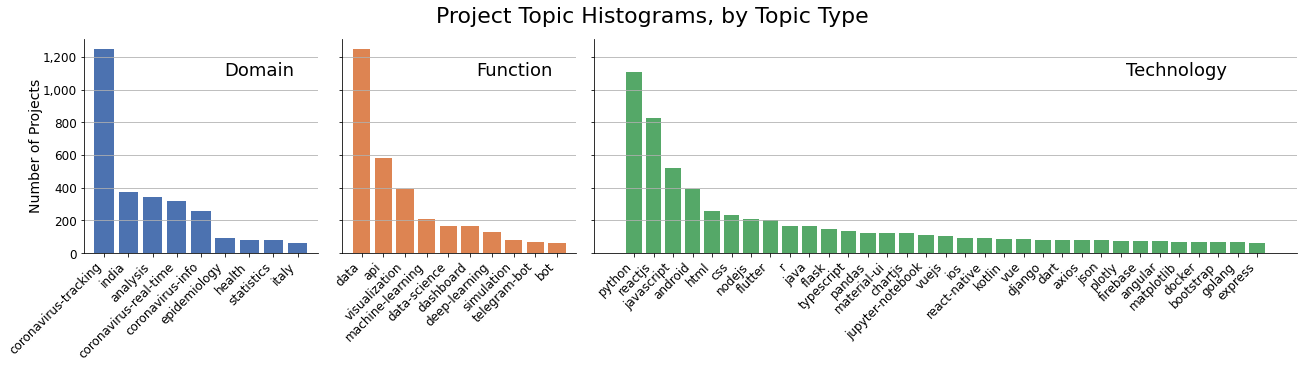

In [4]:
topics = projects['topics'].str.split(', ').dropna()
# print(topics)
flat_topics = topics.explode()
# print(flat_topics)

topic_counts = flat_topics.value_counts()
big_topic_counts = topic_counts[topic_counts > 60]
# print(big_topic_counts)

synonyms = [
    ['covid-19', 'coronavirus', 'covid19', 'covid', 'corona', 'sars-cov-2', 'covid-virus', '2019-ncov', 'covid-2019', 'ncov', 'pandemic', 'virus',
        'coronavirus-globaloutbreak'],
    ['data', 'dataset', 'covid19-data', 'covid-data', 'covid-19-data'],
    ['python', 'python3'],
    ['reactjs', 'react'],
    ['html','html5'],
    ['coronavirus-tracking', 'coronavirus-tracker', 'covid19-tracker', 'tracker'],
    ['css', 'css3'],
    ['android', 'android-app', 'android-application'],
    ['italy', 'covid-19-italy'],
    ['india', 'covid-19-india'],
    ['api','covid-api', 'rest-api'],
    ['visualization', 'data-visualization'],
    ['analysis','coronavirus-analysis', 'data-analysis']
    ]
def index_or_neg(idx, li:list) :
    try: 
        return li.index(idx)
    except ValueError: 
        return -1
    
def syn_find(name:str, arr:list):
    idx = index_or_neg(name,arr)
    return arr[0] if idx >= 0 else None
def syn_mapper(name: str):
    for syn_list in synonyms:
        primary = syn_find(name, syn_list)
        if primary:
            return primary
    return name
primaries = big_topic_counts.index.map(syn_mapper)
big_topic_counts_syn=pd.DataFrame({"primary":primaries, 'count':big_topic_counts.values})
big_topic_counts_syn =big_topic_counts_syn.groupby('primary')['count'].sum().sort_values(ascending=False)

""" Unified histogram of all topics
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(ax=ax, x=big_topic_counts_syn.index, y=big_topic_counts_syn.values)

fig.suptitle('Histogram of projects\' topics', x=.6, y=.85)
ax.set_yscale("log")
ax.set_xlabel('Topic')
ax.set_ylabel('Number of projects')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
ax.yaxis.set_major_formatter(COMMA_FMT)
sns.despine()
plt.grid(axis='y', which='both')
plt.show()
"""

DOMAIN_TT = 'domain'
FUNCTION_TT = 'function'
TECH_TT = 'technology'

topic_types = {
    DOMAIN_TT: { 'title': 'Domain',
                'topics':['covid-19', 'coronavirus-tracking', 'india', 'coronavirus-real-time', 'coronavirus-info', 
                'analysis','epidemiology','health','statistics','italy']},
    FUNCTION_TT: { 'title': 'Function', 
                  'topics':['data', 'api', 'visualization', 'machine-learning','dashboard','data-science','simulation','telegram-bot','bot','deep-learning',]},
    TECH_TT: { 'title': 'Technology',
              'topics':['python', 'reactjs', 'javascript', 'android', 'html', 'css', 'nodejs', 'flutter','r','java','flask','typescript',
             'pandas','material-ui','chartjs','jupyter-notebook','vuejs','react-native','ios','kotlin','vue','django','json',
             'axios','dart','firebase','plotly','angular','golang','docker','bootstrap','express', 'matplotlib']}
}
topic_type_keys = list(topic_types.keys())
df_topics = pd.DataFrame(big_topic_counts_syn)
df_topics = df_topics[df_topics.index != 'covid-19']
def type_find(topic:str) :
    for (typ, type_props) in topic_types.items():
        if topic in type_props['topics']:
            return typ
    return None

typ_map = df_topics.index.map(type_find)
df_topics.insert(1,'typ',typ_map)
df_topics.insert(0,'indexx',df_topics.index)
typ_groups=df_topics.groupby('typ').groups

f, axes = plt.subplots(1, len(topic_types), figsize=(18,5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 3]}, constrained_layout=True)
palette = sns.color_palette('deep', len(topic_types))
f.suptitle('Project Topic Histograms, by Topic Type', fontsize=22 )
for ax_idx,ax in enumerate(axes):
    typ = topic_type_keys[ax_idx]
    title = topic_types[typ]['title']
    typ_topics = df_topics[df_topics.typ == typ]
    ax.bar(x=typ_topics.index, height=typ_topics['count'], color=palette[ax_idx])
    ax.grid(axis='y', which='both')
    if ax_idx == 0: ax.set_ylabel('Number of Projects', fontsize=14, labelpad=0)
    ax.xaxis.set_major_formatter(COMMA_FMT)
    ax.yaxis.set_major_formatter(COMMA_FMT)
    ax.set_xticklabels(typ_topics.index, rotation=45, horizontalalignment='right')
    ax.text(0.9, 0.85, title, fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
    sns.despine()
    
plt.show()

__Notes on topic histograms__

- Most projects have no topics.
- Only the most-tagged topics, with 61 or more projects tagged, are shown.

- Topics that just indicate "covid-19" are omitted: `'covid-19', 'coronavirus', 'covid19', 'covid', 'corona', 'sars-cov-2', 'covid-virus', '2019-ncov', 'covid-2019', 'ncov', 'pandemic', 'virus', and 'coronavirus-globaloutbreak'`

- Many synonymous or closely related topics have been folded together.  Your mileage may differ.  The synonym groups are:

```
    ['data', 'dataset', 'covid19-data', 'covid-data', 'covid-19-data'],
    ['python', 'python3'],
    ['reactjs', 'react'],
    ['html','html5'],
    ['coronavirus-tracking', 'coronavirus-tracker', 'covid19-tracker', 'tracker'],
    ['css', 'css3'],
    ['android', 'android-app', 'android-application'],
    ['italy', 'covid-19-italy'],
    ['india', 'covid-19-india'],
    ['api','covid-api', 'rest-api'],
    ['visualization', 'data-visualization'],
    ['analysis','coronavirus-analysis', 'data-analysis']



```


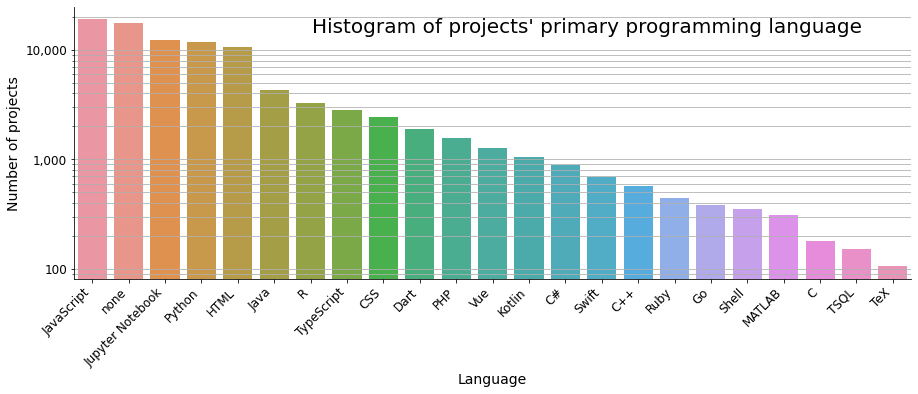

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
categories = projects['primary_language_name'].fillna('none').value_counts()
multicats = categories[categories > 75]

sns.barplot(ax=ax, x=multicats.index, y=multicats.values)

fig.suptitle('Histogram of projects\' primary programming language', x=.6, y=.85)
ax.set_yscale("log")
ax.set_xlabel('Language')
ax.set_ylabel('Number of projects')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')
ax.yaxis.set_major_formatter(COMMA_FMT)
sns.despine()
plt.grid(axis='y', which='both')
plt.show()

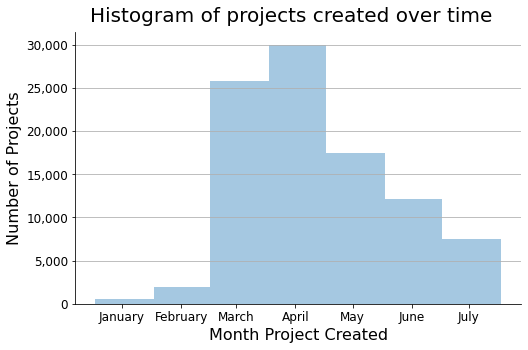

In [6]:
#plot data
months = range(1,9)
first_of_months = [ datetime.date.toordinal(datetime.date(2020, month, 1)) for month in months]
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle('Histogram of projects created over time', y=.95)
# projects['repo_created_day'].hist(bins=10, ax=ax)
sns.distplot(projects['repo_created_day'].dt.date.apply(datetime.date.toordinal), bins=first_of_months, ax=ax, kde=False, norm_hist=False)
sns.despine()
# print(projects['repo_created_day'].dt.date.apply(datetime.date.toordinal))
middle_of_months = [ first+14 for first in first_of_months ]
ax.xaxis.set_major_locator(FixedLocator(middle_of_months))
ax.set_xticklabels([datetime.date.fromordinal(int(item)).strftime('%B') for item in ax.get_xticks()])
ax.yaxis.set_major_formatter(COMMA_FMT)
ax.set_xlabel('Month Project Created', fontsize=16)
ax.set_ylabel('Number of Projects', fontsize=16)
plt.grid(axis='y')
plt.show()
#ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))



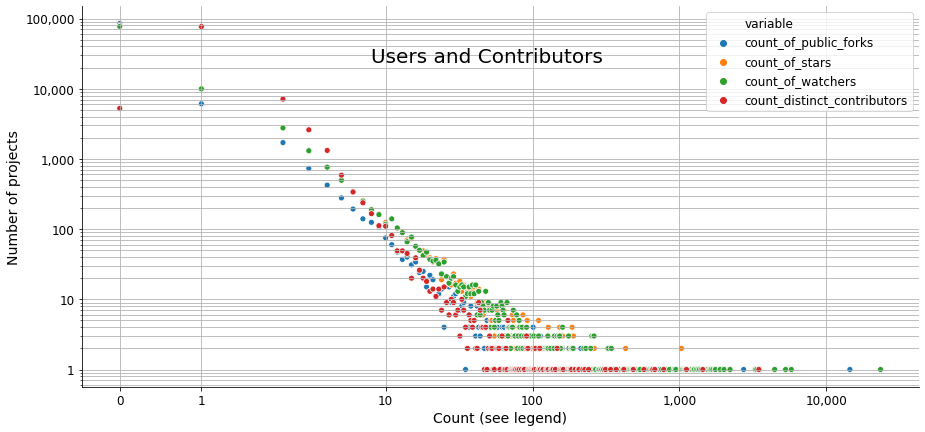

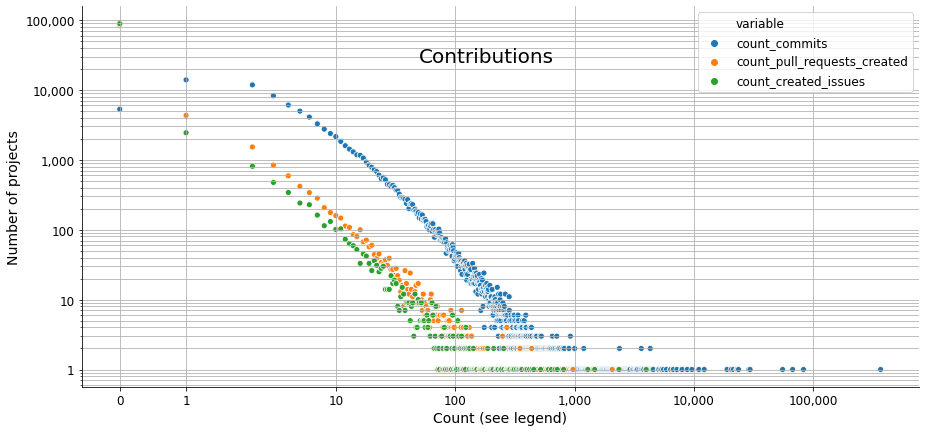

In [7]:
projects['primary_language_name'].fillna('none').astype('category')

counts = [
    'count_of_public_forks',
    'count_of_stars',
    'count_of_watchers',
    'count_distinct_contributors',
    'count_contributions',
    'count_commits',        
    'count_commit_comments', 
    'count_created_issues', 
    'count_pull_requests_created',
    'count_pull_requests_reviews',
    'count_comments_on_issues_and_pull_requests']


#sns.boxplot(data = projects, order=counts, orient = "h")
#plt.show()

countHists = {}
for col in counts:
    countHists[col] = projects[col].value_counts()
    #print(countHists)

def plot_counts(cols, suptitle='suptitle'):
    selectedHists = { col: countHists[col] for col in cols }
    dfHists = pd.DataFrame.from_dict(selectedHists)
    dfLong = pd.melt(dfHists.reset_index(), id_vars='index', value_vars=cols, value_name='n_projects').dropna()
    # print(dfLong)
    f, ax = plt.subplots(figsize=(15,7))
    f.suptitle(suptitle, y=.8)
    sns.scatterplot(data=dfLong, x='index', y='n_projects', hue='variable', ax=ax )
    # sns.distplot(data=dfLong, x='index', y='n_projects', hue='variable', ax=ax )
    sns.despine(offset=0)
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    ax.set_xscale("symlog")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(COMMA_FMT)
    ax.yaxis.set_major_formatter(COMMA_FMT)
    ax.set_xlabel('Count (see legend)')
    ax.set_ylabel('Number of projects')

    plt.grid(axis='both', which='both')
    plt.show()
    
plot_counts([    
    'count_of_public_forks',
    'count_of_stars',
    'count_of_watchers',
    'count_distinct_contributors',
], suptitle='Users and Contributors')    
    
plot_counts([    
    'count_commits',
    'count_pull_requests_created',
    'count_created_issues'
], suptitle='Contributions')    
    


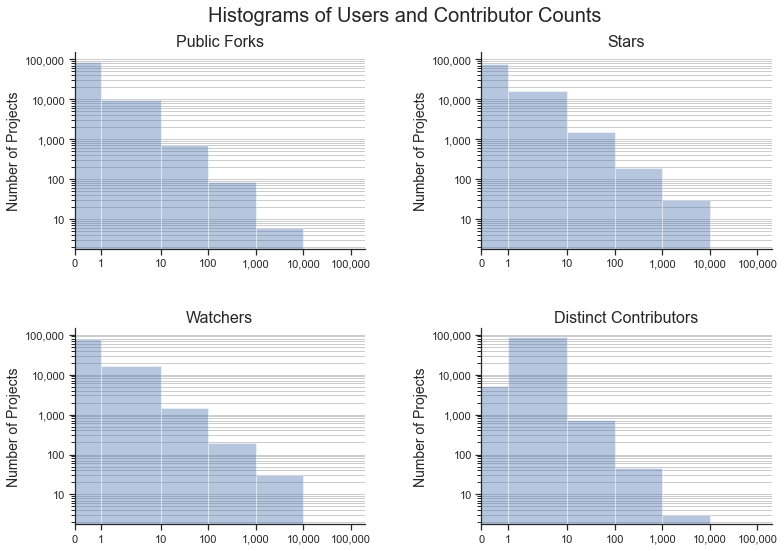

In [8]:
def count_format(col_name):
        lab = col_name.replace('variable = count_','').replace('of_','').replace('_',' ').title()
        return lab

def plot_counts2(cols, suptitle='suptitle'):
    sns.set(style="ticks")
    selected = projects[cols]
    long_frame = pd.melt(selected, value_vars=cols, value_name='n_projects').dropna()

    # print(long_frame)
    g = sns.FacetGrid(long_frame, col='variable', col_wrap=2 if len(cols)>3 else 2, height=4, aspect=1.33)
    g = g.map(sns.distplot, 'n_projects', kde=False, norm_hist=False, bins=[0,1,10,100,1000,10000,100000])
    g.set(xscale="symlog", yscale="log", xlim=(0, 200000), xlabel='')
    g.fig.subplots_adjust(top=.9,wspace=.4, hspace=.4)
    g.fig.suptitle(suptitle)
    for ax in g.axes.flatten():
        ax.grid(axis='y', which='both')
        ax.set_title(count_format(ax.get_title()), fontsize=16)
        ax.set_ylabel('Number of Projects', fontsize=14)
        ax.xaxis.set_major_formatter(COMMA_FMT)
        ax.yaxis.set_major_formatter(COMMA_FMT)
        # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# sns.scatterplot(data=dfLong, x='index', y='n_projects', hue='variable', ax=ax )
    # sns.distplot(data=dfLong, x='index', y='n_projects', hue='variable', ax=ax )
    sns.despine(offset=0)
    plt.show()
    
plot_counts2([    
    'count_of_public_forks',
    'count_of_stars',
    'count_of_watchers',
    'count_distinct_contributors',
], suptitle='Histograms of Users and Contributor Counts')    
    

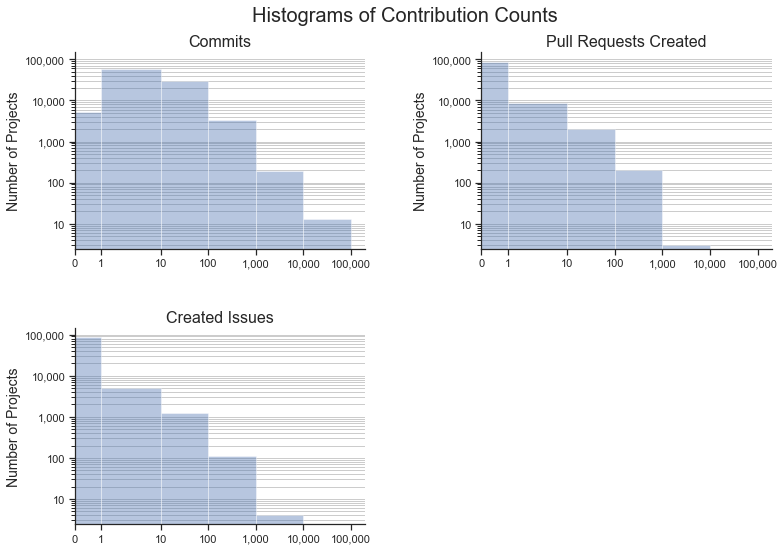

In [9]:
plot_counts2([    
    'count_commits',
    'count_pull_requests_created',
    'count_created_issues'
], suptitle='Histograms of Contribution Counts')    